In [1]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import seaborn as sns

* Loading data

In [4]:
file_path = 'data/BeerAdvocate.tar'
with tarfile.open(file_path, 'r') as tar:
    tar.extractall(path='../data')  
    tar.list()

?rwxrwxrwx gayouf/gayouf   29617210 2017-10-27 18:01:43 beers.csv 
?rwxrwxrwx gayouf/gayouf  729167813 2017-08-03 14:28:54 reviews.txt.gz 
?rwxrwxrwx gayouf/gayouf    9751813 2017-08-07 13:23:35 users.csv 
?rwxrwxrwx gayouf/gayouf     808192 2017-08-04 18:22:30 breweries.csv 
?rwxrwxr-x gayouf/gayouf  926302646 2017-08-03 14:29:24 ratings.txt.gz 


In [5]:
beers_ba = pd.read_csv('../data/beers.csv')
reviews_ba = pd.read_csv('../data/reviews.txt.gz', delimiter='\t', on_bad_lines='skip')
users_ba = pd.read_csv('../data/users.csv')
breweries_ba = pd.read_csv('../data/breweries.csv')
ratings_ba = pd.read_csv('../data/ratings.txt.gz', delimiter='\t', on_bad_lines='skip')

In [7]:
reviews_ba.head(20)

,beer_name: Régab,review_id
0,beer_id: 142544,0
1,brewery_name: Societe des Brasseries du Gabon ...,0
2,brewery_id: 37262,0
3,style: Euro Pale Lager,0
4,abv: 4.5,0
5,date: 1440064800,0
6,user_name: nmann08,0
7,user_id: nmann08.184925,0
8,appearance: 3.25,0
9,aroma: 2.75,0


In [12]:
reviews_ba['Review'] = reviews_ba['beer_name: Régab'].shift(1)  # Shift all items in 'beer_name' column down by 1
reviews_ba.at[0, 'Review'] = "beer_name: Régab"
reviews_ba = reviews_ba.drop('beer_name: Régab', axis=1)
reviews_ba.head()

,review_id,Review
0,0,beer_name: Régab
1,0,beer_id: 142544
2,0,brewery_name: Societe des Brasseries du Gabon ...
3,0,brewery_id: 37262
4,0,style: Euro Pale Lager


In [13]:
# Add review_id based on 16-row structure 
reviews_ba['review_id'] = reviews_ba.index // 16

# Split key-value pairs and filter valid splits
split_data = reviews_ba['Review'].str.split(': ', n=1, expand=True)
split_data = split_data[split_data[1].notna()]  # Remove rows with no :

# Assign key and value columns
reviews_ba[['key', 'value']] = split_data

# Pivot the table to convert key to a column
reviews_ba_pivot = reviews_ba.pivot(index='review_id', columns='key', values='value').reset_index(drop=True)

In [14]:
# Convert the date from Unix timestamp 
reviews_ba_pivot['date'] = pd.to_datetime(reviews_ba_pivot['date'].astype(int), unit='s')
reviews_ba_pivot['year'] = reviews_ba_pivot['date'].dt.year
reviews_ba_pivot['month'] = reviews_ba_pivot['date'].dt.month
reviews_ba_pivot['day'] = reviews_ba_pivot['date'].dt.day

In [15]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    elif month in [12, 1, 2]:
        return 'Winter'

In [16]:
reviews_ba_pivot['season'] = reviews_ba_pivot['month'].apply(get_season)

In [17]:
# Join reviews_ba_pilot to users_ba on "user_id"
reviews_ba_pivot = reviews_ba_pivot.merge(users_ba[['user_id', 'location']], on='user_id', how='left')

In [18]:
# Remove the states to only have the countries
reviews_ba_pivot['country'] = reviews_ba_pivot['location'].str.split(',').str[0]

# Remove the countries to only have the states
reviews_ba_pivot['states'] = reviews_ba_pivot['location'].str.split(',').str[1]

In [19]:
us_reviews = reviews_ba_pivot[reviews_ba_pivot['country'] == 'United States']

In [20]:
us_reviews.head()

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,text,user_id,user_name,year,month,day,season,location,country,states
0,4.5,3.25,2.75,142544,Régab,37262,Societe des Brasseries du Gabon (SOBRAGA),2015-08-20 10:00:00,3.0,3.25,...,"From a bottle, pours a piss yellow color with ...",nmann08.184925,nmann08,2015,8,20,Summer,"United States, Washington",United States,Washington
1,4.5,3.0,3.5,19590,Barelegs Brew,10093,Strangford Lough Brewing Company Ltd,2009-02-20 11:00:00,3.5,3.5,...,Pours pale copper with a thin head that quickl...,stjamesgate.163714,StJamesGate,2009,2,20,Winter,"United States, New York",United States,New York
5,4.8,4.25,4.5,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2013-02-13 11:00:00,3.75,3.25,...,This was a 12 oz bottle poured into a snifter....,brewdude1982.691169,brewdude1982,2013,2,13,Winter,"United States, North Carolina",United States,North Carolina
6,4.8,4.0,3.75,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2013-01-09 11:00:00,3.75,3.5,...,Poured from a 12 ounce bottle into a pilsner g...,agentmunky.409755,AgentMunky,2013,1,9,Winter,"United States, New York",United States,New York
7,4.8,3.0,3.5,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2012-11-17 11:00:00,2.5,2.5,...,Beer poured from bottle into a Nonic shaped pi...,ferrari29.320392,ferrari29,2012,11,17,Fall,"United States, Illinois",United States,Illinois


* General scores per seasons

/var/folders/wg/t61x80w10d9dtstnmmlr6vmc0000gn/T/ipykernel_25335/4039344655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_reviews['overall'] = pd.to_numeric(us_reviews['overall'], errors='coerce')


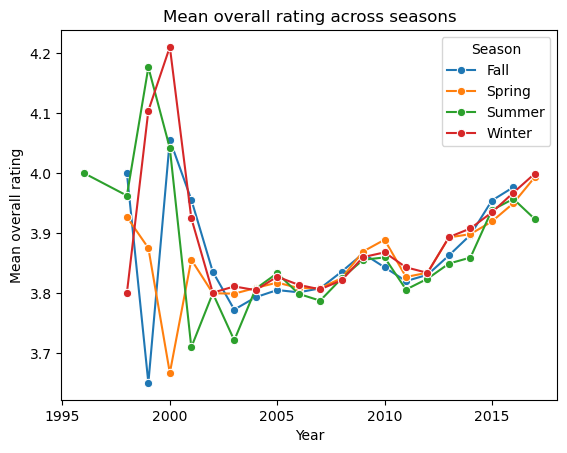

In [139]:
us_reviews['overall'] = pd.to_numeric(us_reviews['overall'], errors='coerce')
seasonal_overall = us_reviews.groupby(['season', 'year'])['overall'].mean().reset_index()

sns.lineplot(data=seasonal_overall, x='year', y='overall', hue='season', marker='o')
plt.title('Mean overall rating across seasons')
plt.xlabel('Year')
plt.ylabel('Mean overall rating')
plt.legend(title='Season')
plt.show()

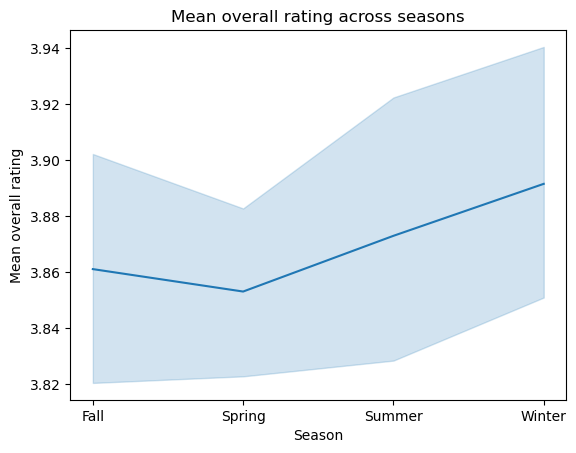

In [140]:
sns.lineplot(data=seasonal_overall, x='season', y='overall')
plt.title('Mean overall rating across seasons')
plt.xlabel('Season')
plt.ylabel('Mean overall rating')
plt.show()

* Average rating per beer type for each season

In [26]:
us_reviews.columns

Index(['abv', 'appearance', 'aroma', 'beer_id', 'beer_name', 'brewery_id',
       'brewery_name', 'date', 'overall', 'palate', 'rating', 'style', 'taste',
       'text', 'user_id', 'user_name', 'year', 'month', 'day', 'season',
       'location', 'country', 'states'],
      dtype='object')

In [28]:
beers_ba.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN


In [29]:
us_reviews['style'].head()

0     Euro Pale Lager
1    English Pale Ale
5    English Pale Ale
6    English Pale Ale
7    English Pale Ale
Name: style, dtype: object

In [32]:
us_reviews['rating'].head()

0    2.88
1    3.67
5    3.91
6    3.64
7    2.77
Name: rating, dtype: object

In [138]:
us_reviews['abv'] = pd.to_numeric(us_reviews['abv'], errors='coerce')
us_reviews['appearance'] = pd.to_numeric(us_reviews['appearance'], errors='coerce')
us_reviews['aroma'] = pd.to_numeric(us_reviews['aroma'], errors='coerce')
us_reviews['palate'] = pd.to_numeric(us_reviews['palate'], errors='coerce')
us_reviews['rating'] = pd.to_numeric(us_reviews['rating'], errors='coerce')
us_reviews['taste'] = pd.to_numeric(us_reviews['taste'], errors='coerce')
us_reviews['overall'] = pd.to_numeric(us_reviews['overall'], errors='coerce')

/var/folders/wg/t61x80w10d9dtstnmmlr6vmc0000gn/T/ipykernel_25335/2352949972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_reviews['abv'] = pd.to_numeric(us_reviews['abv'], errors='coerce')
/var/folders/wg/t61x80w10d9dtstnmmlr6vmc0000gn/T/ipykernel_25335/2352949972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_reviews['appearance'] = pd.to_numeric(us_reviews['appearance'], errors='coerce')
/var/folders/wg/t61x80w10d9dtstnmmlr6vmc0000gn/T/ipykernel_25335/2352949972.py:3: SettingWithCopyWarni

In [96]:
us_reviews_grouped = us_reviews.groupby(['style', 'season', 'year']).agg({'abv': 'mean', 
                                                                          'appearance': 'mean',
                                                                            'aroma': 'mean',
                                                                            'overall': 'mean',
                                                                            'palate': 'mean',
                                                                            'rating': 'mean',
                                                                            'taste': 'mean'
}).reset_index()

nb_reviews = us_reviews.groupby(['style', 'season', 'year']).size().reset_index(name='nb_reviews')

us_reviews_grouped = pd.merge(us_reviews_grouped, nb_reviews, on=['style', 'season', 'year'], how='left')

In [97]:
us_reviews_grouped.head()

,style,season,year,abv,appearance,aroma,overall,palate,rating,taste,nb_reviews
0,Altbier,Fall,2000,4.800000,3.000000,4.000000,4.000000,4.000000,3.940000,4.000000,1
1,Altbier,Fall,2001,5.120000,3.800000,3.600000,4.000000,4.000000,3.892000,4.000000,5
2,Altbier,Fall,2002,5.276885,3.843750,3.828125,3.906250,3.765625,3.866563,3.898438,64
3,Altbier,Fall,2003,5.134957,3.744186,3.476744,3.802326,3.631783,3.627674,3.612403,129
4,Altbier,Fall,2004,5.143566,3.810219,3.452555,3.857664,3.656934,3.664526,3.675182,137


In [ ]:
# Select the top 2% beer style in terms of number of reviews 

reviews_per_style = us_reviews.groupby('style').size().reset_index(name='nb_reviews')
total_reviews = reviews_per_style['nb_reviews'].sum()
reviews_per_style['proportion'] = reviews_per_style['nb_reviews']/total_reviews
top_styles = reviews_per_style[reviews_per_style['proportion']> 0.02]
top_styles_list = top_styles['style'].tolist()
us_reviews_top_styles = us_reviews_grouped[us_reviews_grouped['style'].isin(top_styles_list)]

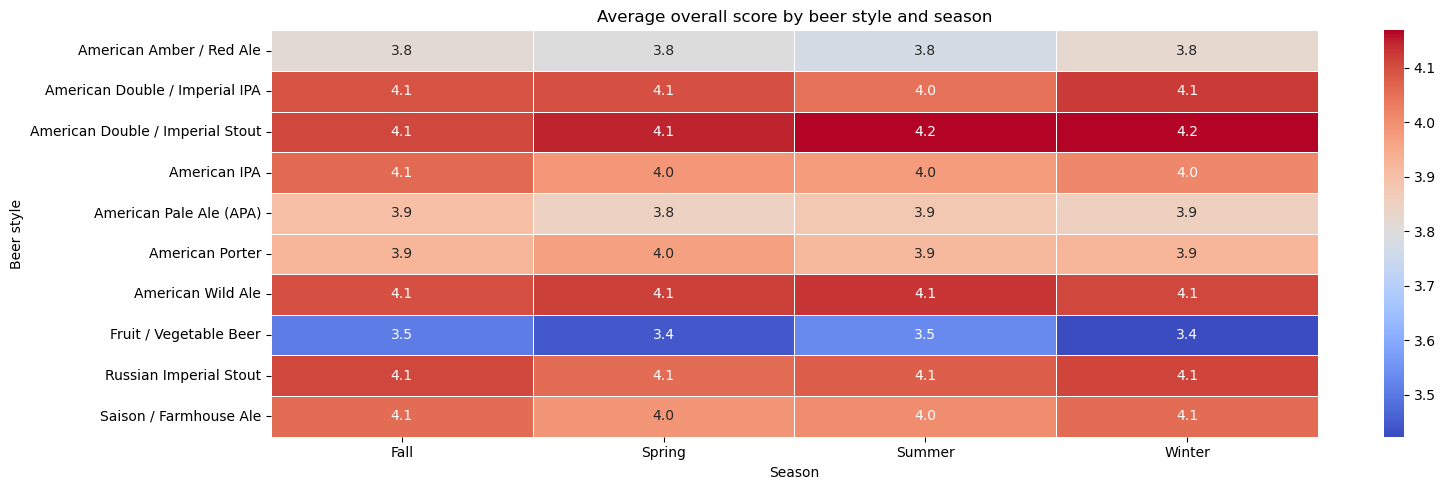

In [135]:
# Plot the average overall score by beer style and season
styles = us_reviews_top_styles['style'].unique()

heatmap_data_season = us_reviews_top_styles.groupby(['style', 'season'])['overall'].mean().unstack(fill_value=0)

plt.figure(figsize=(16, len(styles) * 0.5)) 
sns.heatmap(heatmap_data_season, cmap='coolwarm', annot=True, fmt='.1f', cbar=True, linewidths=0.5)

plt.title('Average overall score by beer style and season')
plt.xlabel('Season')
plt.ylabel('Beer style')

plt.tight_layout()
plt.show()

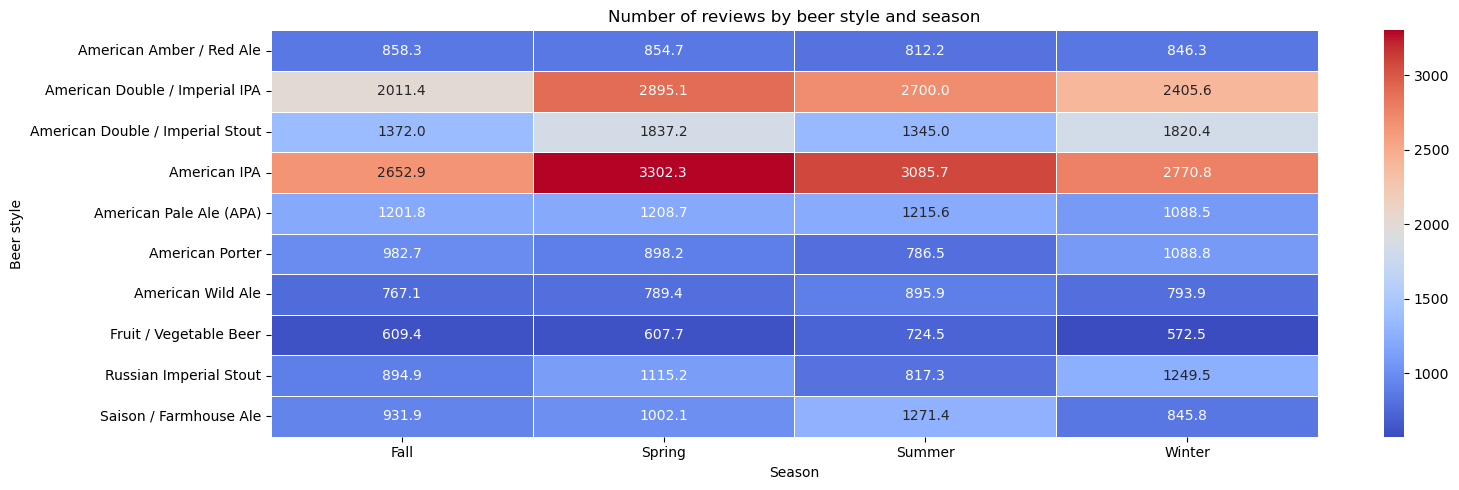

In [ ]:
# Plot the number of reviews per style per season

heatmap_season_nbreviews = us_reviews_top_styles.groupby(['style', 'season'])['nb_reviews'].mean().unstack(fill_value=0)

plt.figure(figsize=(16, len(styles) * 0.5)) 
sns.heatmap(heatmap_season_nbreviews, cmap='coolwarm', annot=True, fmt='.1f', cbar=True, linewidths=0.5)

plt.title('Number of reviews by beer style and season')
plt.xlabel('Season')
plt.ylabel('Beer style')

plt.tight_layout()
plt.show()

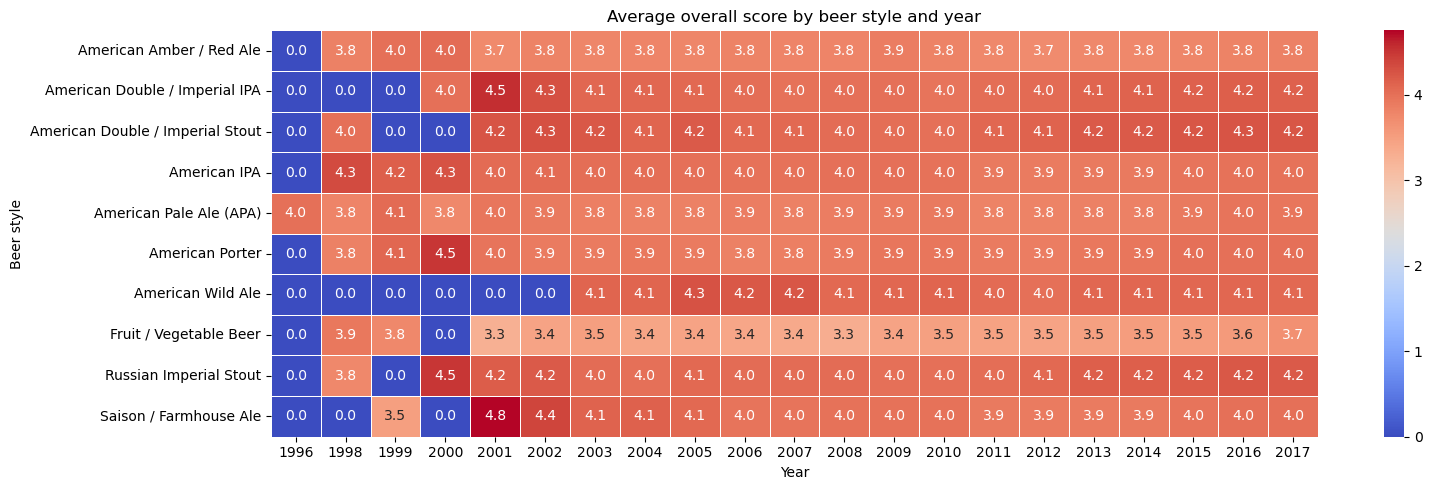

In [ ]:
# Plot the average overall score by beer style and year

heatmap_data_year = us_reviews_top_styles.groupby(['style', 'year'])['overall'].mean().unstack(fill_value=0)

plt.figure(figsize=(16, len(styles) * 0.5)) 
sns.heatmap(heatmap_data_year, cmap='coolwarm', annot=True, fmt='.1f', cbar=True, linewidths=0.5)

plt.title('Average overall score by beer style and year')
plt.xlabel('Year')
plt.ylabel('Beer style')

plt.tight_layout()
plt.show()

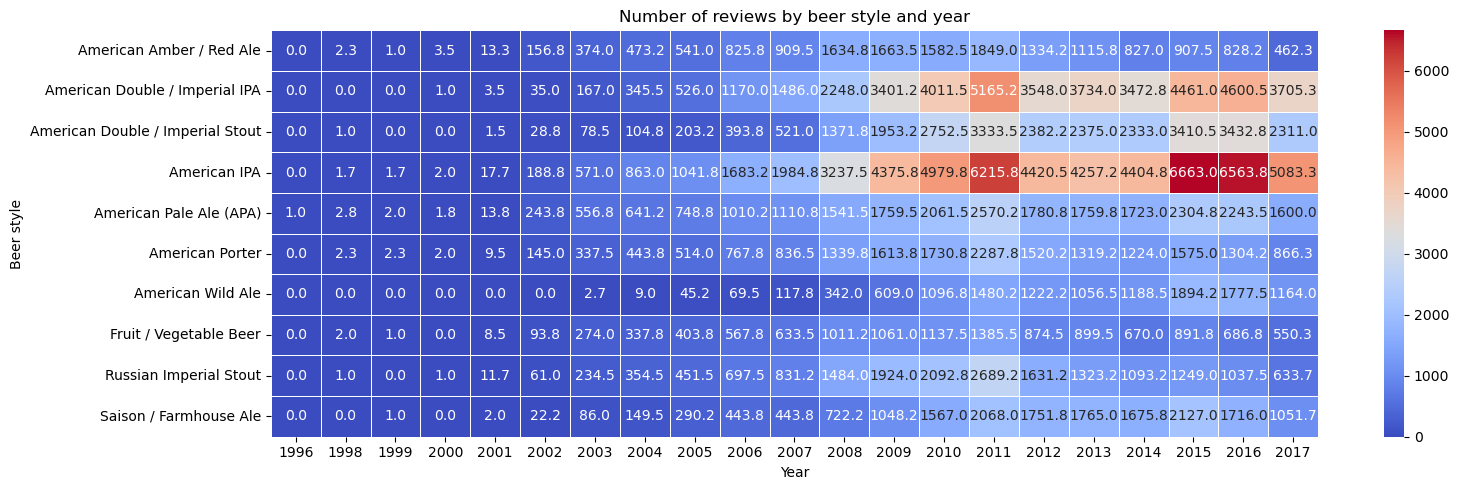

In [137]:
# Plot the number of reviews per style per year

heatmap_year_nbreviews = us_reviews_top_styles.groupby(['style', 'year'])['nb_reviews'].mean().unstack(fill_value=0)

plt.figure(figsize=(16, len(styles) * 0.5)) 
sns.heatmap(heatmap_year_nbreviews, cmap='coolwarm', annot=True, fmt='.1f', cbar=True, linewidths=0.5)

plt.title('Number of reviews by beer style and year')
plt.xlabel('Year')
plt.ylabel('Beer style')

plt.tight_layout()
plt.show()

Based on the number of reviews per style per year, we may need to truncate these elements to obtain more meaningful results.

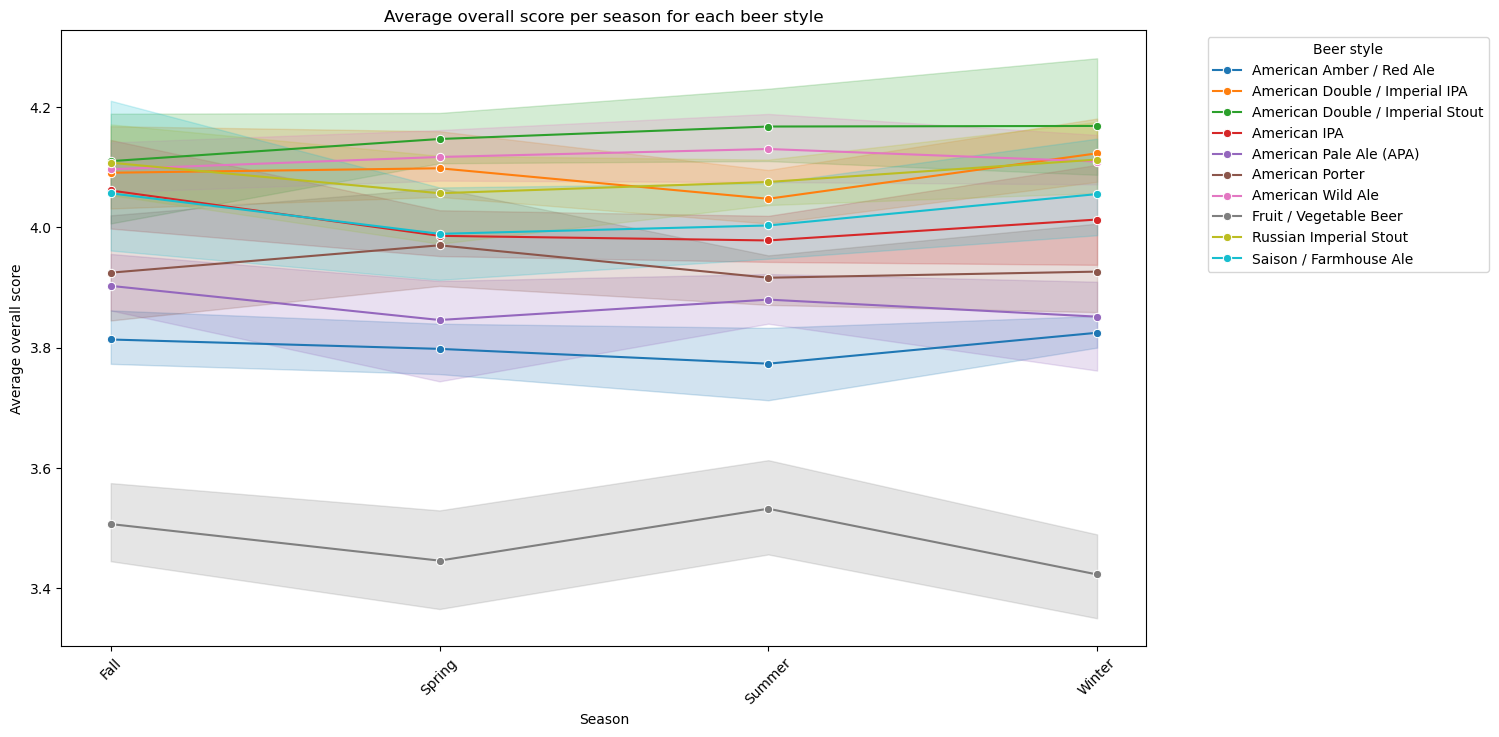

In [113]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=us_reviews_top_styles, x='season', y='overall', hue='style', marker='o')

plt.title('Average overall score per season for each beer style')
plt.xlabel('Season')
plt.ylabel('Average overall score')
plt.xticks(rotation=45)  
plt.legend(title='Beer style', bbox_to_anchor=(1.05, 1), loc='upper left')  

* Coefficient of variability accross style (varibility of the ratings for each style)

In [114]:
mean_scores = us_reviews_top_styles.groupby(['style', 'season'])['overall'].mean()
std_scores = us_reviews_top_styles.groupby(['style', 'season'])['overall'].std()
variability = (std_scores / mean_scores).reset_index()
variability.rename(columns={'overall': 'coefficient_of_variation'}, inplace=True)

In [115]:
variability.head()

,style,season,coefficient_of_variation
0,American Amber / Red Ale,Fall,0.026094
1,American Amber / Red Ale,Spring,0.025925
2,American Amber / Red Ale,Summer,0.035869
3,American Amber / Red Ale,Winter,0.016323
4,American Double / Imperial IPA,Fall,0.037435


In [116]:
variability_season = variability.groupby('style')['coefficient_of_variation'].mean().reset_index()
variability_season.rename(columns={'overall': 'coefficient_of_variation'}, inplace=True)
variability_season.head()

,style,coefficient_of_variation
0,American Amber / Red Ale,0.026052
1,American Double / Imperial IPA,0.029332
2,American Double / Imperial Stout,0.038525
3,American IPA,0.033131
4,American Pale Ale (APA),0.037759


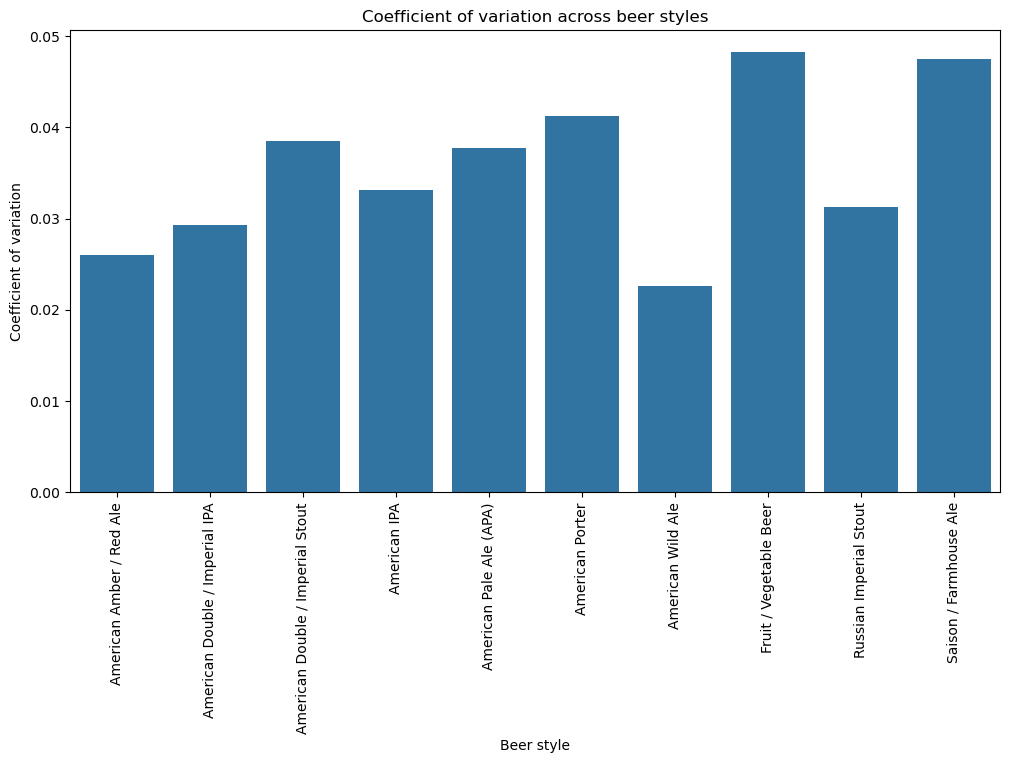

In [118]:
plt.figure(figsize=(12, 6))
sns.barplot(x='style', y='coefficient_of_variation', data=variability_season)

plt.title('Coefficient of variation across beer styles')
plt.xlabel('Beer style')
plt.ylabel('Coefficient of variation')
plt.xticks(rotation=90) 
plt.show()

In [119]:
variability_season.head()

,style,coefficient_of_variation
0,American Amber / Red Ale,0.026052
1,American Double / Imperial IPA,0.029332
2,American Double / Imperial Stout,0.038525
3,American IPA,0.033131
4,American Pale Ale (APA),0.037759


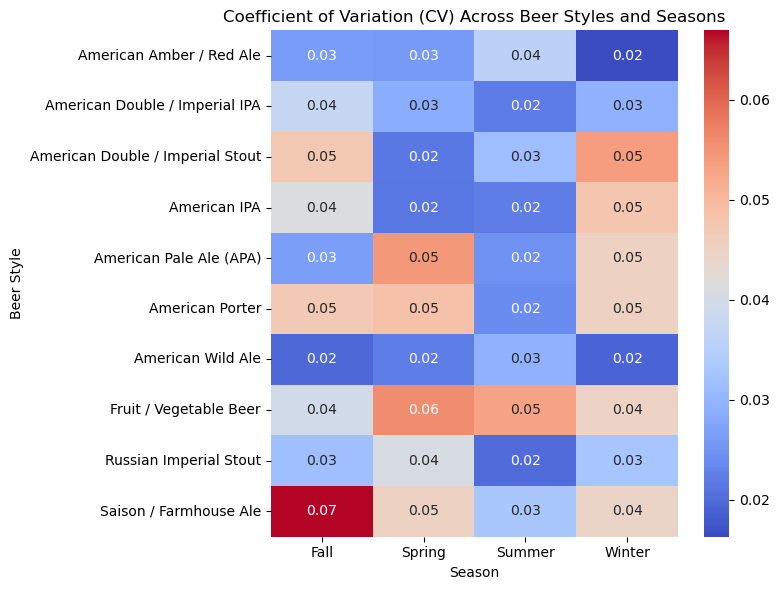

In [123]:
cv_pivot = variability.pivot(index='style', columns='season', values='coefficient_of_variation')

plt.figure(figsize=(8, 6))
sns.heatmap(cv_pivot, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

plt.title('Coefficient of Variation (CV) Across Beer Styles and Seasons')
plt.xlabel('Season')
plt.ylabel('Beer Style')

plt.tight_layout()
plt.show()

* Coefficient of variability per style per year

In [124]:
mean_scores_year = us_reviews_top_styles.groupby(['style', 'year'])['overall'].mean()
std_scores_year = us_reviews_top_styles.groupby(['style', 'year'])['overall'].std()
variability_year = (std_scores_year / mean_scores_year).reset_index()
variability_year.rename(columns={'overall': 'coefficient_of_variation'}, inplace=True)

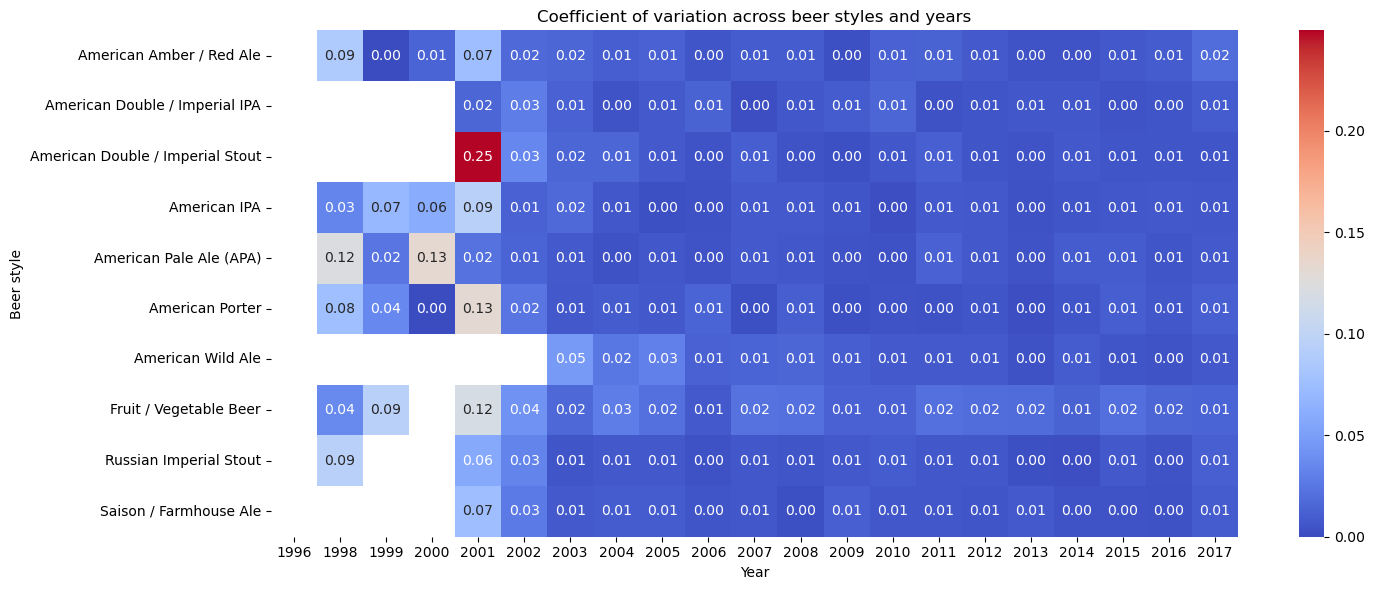

In [129]:
cv_pivot_year = variability_year.pivot(index='style', columns='year', values='coefficient_of_variation')

plt.figure(figsize=(15, 6))
sns.heatmap(cv_pivot_year, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

plt.title('Coefficient of variation across beer styles and years')
plt.xlabel('Year')
plt.ylabel('Beer style')

plt.tight_layout()
plt.show()

Across years, almost no variability in the overall ratings is observed per beer style, as long as there is a sufficient number of reviews. The users seem to have agreed on how well the beer is liked.